## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from timeit import default_timer as timer
from scipy.linalg import toeplitz 

## my own functions
from utils import moments_estimate, format_data, sample_PLN
import seaborn as sns 
import PLN

import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

## Read oaks data set

In [2]:
'''
Y = read_csv('oaks_counts.csv', sep=',').to_numpy()
O = read_csv('oaks_offsets.csv', sep=',').to_numpy()
data = format_data(counts = Y, offsets = np.log(O))
# Initialization of the variational parameters
M0, S0 = moments_estimate(Y, np.log(O))
'''

"\nY = read_csv('oaks_counts.csv', sep=',').to_numpy()\nO = read_csv('oaks_offsets.csv', sep=',').to_numpy()\ndata = format_data(counts = Y, offsets = np.log(O))\n# Initialization of the variational parameters\nM0, S0 = moments_estimate(Y, np.log(O))\n"

In [9]:
d = 4 # nb of cavariates
n = 3000; p = 200

In [10]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(0.95**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(0.98**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))

In [11]:
torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.9**np.arange(p)))
true_Sigma = build_block_Sigma(p,4)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y,Z = sample_model.sample(true_Sigma,true_beta, O, covariates)

data = format_data(counts = Y, offsets = np.log(O.numpy()))

M0, S0 = moments_estimate(Y, np.log(O.numpy()))

/home/bastien/Documents/Stage/PLNpy/utils.py:20: RuntimeWarning: invalid value encountered in log
  return np.sum(v * np.log(v) - v + np.log(8 * v ** 3 + 4 * v ** 2 + v + 1/30)/6 + np.log(np.pi)/2)


<AxesSubplot:>

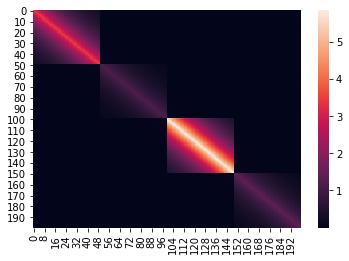

In [12]:
sns.heatmap(true_Sigma)

## Test various optimizer for standard PLN

In [13]:
# Instantiating PLN model with full covariance
myPLN = PLN.full_covariance(data)

### Nlopt solver with CCSAQ on profiled ELBO

In [10]:
start = timer()
# Optimization with the CCSA solver from NLopt
res_nlopt = myPLN.fit_profiled_variational_objective(M0, S0, solver = 'nlopt', ftol = 1e-16)
end = timer()
time_nlopt = end - start

Sigma_profiled = myPLN.Sigma
B_profiled = myPLN.B

MSE :  0.5817353816631214


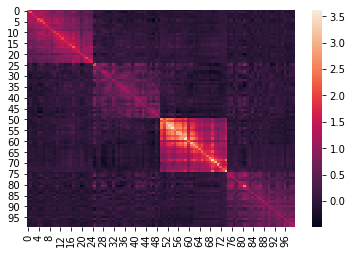

In [13]:
sns.heatmap(Sigma_profiled)
print('MSE : ', np.mean((Sigma_profiled-true_Sigma.numpy())**2))

### Pytorch solver with RProp and auto-grad on profiled ELBO

In [14]:
start = timer()
# Optimization with Rprop solver from Pytorch with autograd
res_torch = myPLN.fit_profiled_variational_objective(M0, S0, solver = 'torch', device = device, lr = 1, nsteps=100, ftol = 1e-3)
end = timer()
time_torch = end - start

Sigma_profiled_torch = myPLN.Sigma
B_profiled_torch = myPLN.B

MSE_Sigma :  0.03542052465375
MSE_beta :  2.0573105256999096


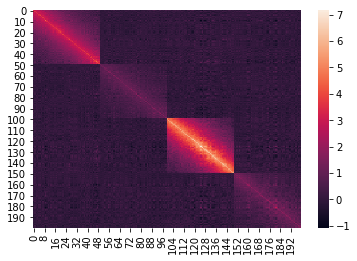

In [15]:
sns.heatmap(Sigma_profiled_torch)
print('MSE_Sigma : ', np.mean((Sigma_profiled_torch-true_Sigma.numpy())**2))
print('MSE_beta : ', np.mean((B_profiled_torch-true_beta.numpy())**2))

In [16]:
print(time_torch)

20.936257125998964


### V-EM

In [17]:
start = timer()
# Optimization with the CCSA solver from NLopt
res_VEM = myPLN.fit_variational_objective(M0, S0)
end = timer()
time_vem = end - start

Sigma_VEM = myPLN.Sigma
B_VEM = myPLN.B

/home/bastien/Documents/Stage/PLNpy/PLN.py:69: RuntimeWarning: overflow encountered in exp
  A = np.exp(self._data['O'] + M + .5 * S2)


Step # 0, loss: [189707.6532908], delta: [1.]
Step # 1, loss: [164353.59056124], delta: [0.15426534]
Step # 2, loss: [164340.65918608], delta: [7.86864019e-05]
Step # 3, loss: [164336.46306513], delta: [2.55337183e-05]
Step # 4, loss: [164332.83982926], delta: [2.20481547e-05]
Step # 5, loss: [164329.16790445], delta: [2.23449364e-05]
Step # 6, loss: [164326.67981204], delta: [1.51411348e-05]
Step # 7, loss: [164324.87725909], delta: [1.09694465e-05]
Step # 8, loss: [164321.17160319], delta: [2.25512991e-05]
Step # 9, loss: [164316.28782192], delta: [2.9721833e-05]
Step # 10, loss: [164313.27008735], delta: [1.83657386e-05]
Step # 11, loss: [164312.26934506], delta: [6.09049037e-06]
Step # 12, loss: [164306.17632042], delta: [3.70833573e-05]
Step # 13, loss: [164283.72395626], delta: [0.00013667]
Step # 14, loss: [164280.98090852], delta: [1.66972934e-05]
Step # 15, loss: [164238.46468511], delta: [0.00025887]
Step # 16, loss: [164220.85780924], delta: [0.00010721]
Step # 17, loss: [16

MSE_VEM :  0.1115400528714935
MSE_VEM :  2.256241656998681


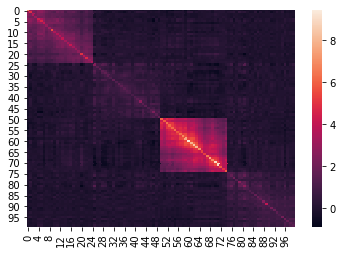

In [20]:
sns.heatmap(Sigma_VEM)
print('MSE_VEM : ', np.mean((Sigma_VEM-true_Sigma.numpy())**2))
print('MSE_VEM : ', np.mean((B_VEM-true_beta.numpy())**2))

## Some outputs

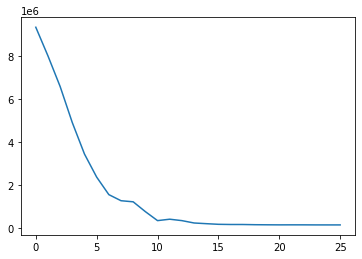

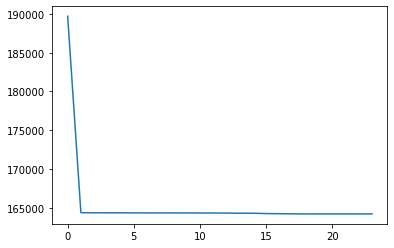

157007.93327847344
106959.33555054347
164193.86959707324
8.102322488999562
0.3421969409992016
108.4374149209998


In [21]:
plt.plot(res_torch['objective'][5:])
plt.show()
plt.plot(res_VEM['objective'])
plt.show()

print(res_nlopt['criterion'])
print(res_torch['criterion'])
print(res_VEM['criterion'])
print(time_nlopt)
print(time_torch)
print(time_vem)


pofiled : 


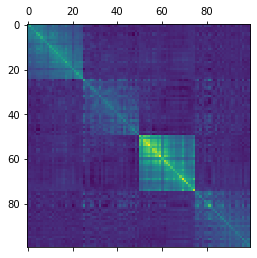

profiled_torch


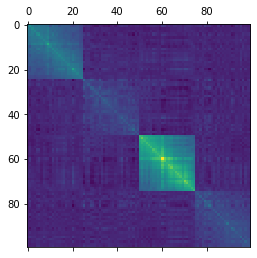

VEM


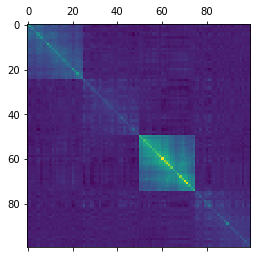

pofiled : 


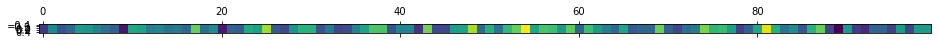

profiled_torch


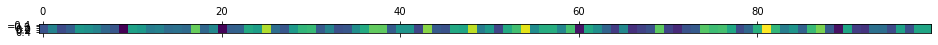

VEM


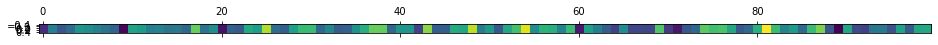

In [30]:
print('pofiled : ')
plt.matshow(Sigma_profiled)
plt.show()
print('profiled_torch')
plt.show()
plt.matshow(Sigma_profiled_torch)
plt.show()
print('VEM')
plt.matshow(Sigma_VEM)
plt.show()
print('pofiled : ')
plt.matshow(B_profiled)
plt.show()
print('profiled_torch')
plt.matshow(B_profiled_torch)
plt.show()
print('VEM')
plt.matshow(B_VEM)
plt.show()


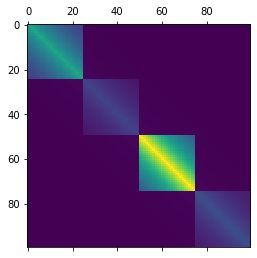

In [29]:
plt.matshow(true_Sigma)